In [1]:
from src.utils.audio import record_with_arecord, stt_pipeline
from src.utils.file_io import read_text, write_text_file
from src.utils.config import *
# DEVICE_PORT, INPUT_FILE, OUTPUT_FILE, ACTIONS_FILE, MEMORY_FILE, HISTORY_FILE, REPLY_FILE

# langggraph_split_files
from src.nodes.langgraph_split_files.actions_schema import ActionDict
from src.nodes.langgraph_split_files.parser_fastpath import parse_fastpath, apply_memory_rules
from src.nodes.langgraph_split_files.parser_gemini import parse_with_gemini
from src.nodes.langgraph_split_files.validator import validate_actions
from src.nodes.langgraph_split_files.hardware_led import setup as led_setup, set_led, cleanup as led_cleanup
from src.nodes.langgraph_split_files.hardware_fan import setup as fan_setup, set_fan, cleanup as fan_cleanup
from src.nodes.langgraph_split_files.hardware_7seg import SevenSegDisplay
import src  # 導入包以訪問 disp

# langgraph modules
from typing import TypedDict, Annotated, List, Dict, Any, Optional # Imports all the data types we need
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
import time

In [2]:
class AgentState(TypedDict):
    input_text: str                    # 使用者輸入的文字
    raw_actions: List[ActionDict]      # 解析器輸出的原始動作
    validated_actions: List[ActionDict] # 驗證後的動作（可選）
    status: str                        # 當前狀態: "start", "record", "analyzed", "fastpath_parsed", "gemini_parsed", "parse_failed", "executed", "error"
    memory_rules: Dict[str, str]       # 記憶規則（從 parser_fastpath）
    history: Annotated[List[Dict[str, Any]], add_messages]  # 對話歷史
    last_input_time: float             # 最後輸入時間戳
    needs_clarification: bool = False  # 是否需要澄清
    clarification_message: Optional[str] = None  # 澄清訊息
    
'''
def record(state: AgentState) -> AgentState:
    """樹莓派的錄音節點"""
    wav_path = record_with_arecord(duration=4, device=DEVICE_PORT)
    if not wav_path:
        print("record node error")
    state["status"] = "record"
    state["last_input_time"] = time.time()  # 更新時間戳
    return state
'''

def record_analyze(state: AgentState) -> AgentState:
    """whisper.cpp解析.wav檔案並寫入input.txt"""
    text = stt_pipeline(duration=4, device=DEVICE_PORT)
    if text:
        write_text_file(INPUT_FILE, text)  # 寫檔
        state["input_text"] = text
        state["status"] = "analyzed"
        state["last_input_time"] = time.time()  # 更新時間戳
    else:
        state["status"] = "analyze_error"
    return state

def parse_actions(state: AgentState) -> AgentState:
    """決定用fastpath or gemini_parsed"""
    text = state["input_text"]

    # 先試 fastpath（記憶 + 快速解析）
    actions = parse_fastpath(text)
    if actions is not None:
        state["raw_actions"] = actions
        state["status"] = "fastpath_parsed"
    else:
        # 再用 gemini
        actions = parse_with_gemini(text)
        state["raw_actions"] = actions
        state["status"] = "gemini_parsed" if actions else "parse_failed"

    return state

def validate_actions_node(state: AgentState) -> AgentState:
    """驗證動作合法性"""
    
    validated = validate_actions(state["raw_actions"]) #可能為空列表，需返回錄音階段
    state["validated_actions"] = validated
    
    if not validated:  # 如果沒有有效動作
        state["needs_clarification"] = True
        state["clarification_message"] = "抱歉，我無法理解您的指令。請重新說一次，例如：開啟廚房燈。"
        state["status"] = "needs_clarification"
    else:
        state["status"] = "validated"
        state["needs_clarification"] = False
    
    return state

def direct_action(state: AgentState) -> AgentState:
    """根據動作類型呼叫對應硬件函式"""
    
    for action in state["validated_actions"]:
        action_type = action["type"]
        
        if action_type == "SET_TEMP":
            # 設定溫度 - 呼叫7段顯示器
            temp = action["value"]
            disp.set_temp(temp)
            print(f"設定溫度為: {temp}°C")
            
        elif action_type == "FAN":
            # 開關風扇
            state = action["state"]  # "on" 或 "off"
            set_fan(state)
            print(f"風扇: {state}")
            
            # 如果有持續時間，處理定時關閉
            duration = action.get("duration")
            if duration and state == "on":
                # 可以啟動定時器線程來自動關閉
                pass
                
        elif action_type == "LED":
            # 開關LED燈
            location = action["location"]  # "KITCHEN", "LIVING", "GUEST"
            state = action["state"]       # "on" 或 "off"
            set_led(location, state)
            print(f"{location}燈: {state}")
            
            # 如果有持續時間，處理定時關閉
            duration = action.get("duration")
            if duration and state == "on":
                # 可以啟動定時器線程來自動關閉
                pass
    
    state["status"] = "executed"
    return state

def init_hardware_node(state: AgentState) -> AgentState:
    """初始化所有硬件"""
    # 7段顯示器
    global disp
    disp = SevenSegDisplay()
    disp.setup()
    disp.start()
    
    # 風扇
    fan_setup()
    
    # LED
    led_setup()
    
    state["status"] = "hardware_initialized"
    return state

def execute_hardware(state: AgentState) -> AgentState:
    """執行硬件動作"""
    # 硬件已在 main.py 中初始化，這裡只執行動作
    
    # 執行動作
    for action in state["validated_actions"]:
        if action["type"] == "SET_TEMP":
            src.disp.set_temp(action["value"])
        elif action["type"] == "FAN":
            set_fan(action["state"])
        elif action["type"] == "LED":
            set_led(action["location"], action["state"])
    
    state["status"] = "executed"
    return state

def cleanup_hardware_node(state: AgentState) -> AgentState:
    """清理所有硬件"""
    try:
        disp.cleanup()
        fan_cleanup()
        led_cleanup()
    except Exception as e:
        print(f"清理硬件時發生錯誤: {e}")
    
    state["status"] = "cleaned"
    return state

def update_history(state: AgentState) -> AgentState:
    """更新歷史記錄"""
    from src.nodes.langgraph_split_files.parser_fastpath import push_history
    
    # 記錄這輪對話
    user_text = state.get("input_text", "")
    result = {
        "actions": state.get("validated_actions", []),
        "status": state["status"]
    }
    push_history(user_text, result)
    
    state["status"] = "history_updated"
    return state

def check_end(state: AgentState) -> AgentState:
    """檢查是否結束對話的節點"""
    # 檢查超時（例如超過5分鐘無輸入）
    current_time = time.time()
    last_input = state.get("last_input_time", current_time)
    if current_time - last_input > 5:  # 5秒鐘
        state["status"] = "timeout_end"
        return state
    
    # 檢查用戶是否說了結束詞
    text = state.get("input_text", "").lower()
    if any(word in text for word in ["結束", "停止", "再見", "end", "stop", "bye"]):
        state["status"] = "user_end"
        return state
    
    # 檢查是否需要澄清
    if state.get("needs_clarification", False):
        state["status"] = "needs_clarification"
        return state
    
    state["status"] = "continue"
    return state

def should_end(state: AgentState) -> str:
    """條件函式：決定是否結束"""
    if state.get("status") in ["timeout_end", "user_end", "needs_clarification"]:
        return "end"
    return "continue"

def clarify_or_continue(state: AgentState) -> AgentState:
    """澄清或繼續"""
    if state.get("needs_clarification", False):
        # 輸出澄清訊息（例如通過 TTS 或寫入文件）
        message = state.get("clarification_message", "請重新輸入指令。")
        print(f"澄清訊息: {message}")  # 這裡可以替換為 TTS 或寫入 reply.txt
        write_text_file(REPLY_FILE, message)  # 假設寫入回覆文件
        # 重置標誌
        state["needs_clarification"] = False
        state["clarification_message"] = None
    
    state["status"] = "ready_for_next"
    return state

In [3]:
# 建立圖
graph = StateGraph(AgentState)

# 加入所有節點
graph.add_node("record_analyze", record_analyze)
graph.add_node("parse_actions", parse_actions)
graph.add_node("validate_actions", validate_actions_node)
graph.add_node("execute_hardware", execute_hardware)
graph.add_node("update_history", update_history)
graph.add_node("check_end", check_end)
graph.add_node("clarify_or_continue", clarify_or_continue)

# 設定起始點
graph.set_entry_point("record_analyze")

# 設定邊緣
graph.add_edge("record_analyze", "parse_actions")
graph.add_edge("parse_actions", "validate_actions")
graph.add_edge("validate_actions", "execute_hardware")
graph.add_edge("execute_hardware", "update_history")
graph.add_edge("update_history", "check_end")

# 條件邊緣：根據 check_end 的結果
graph.add_conditional_edges(
    "check_end",
    should_end,  # 使用新的條件函式
    {
        "end": END,
        "continue": "clarify_or_continue"
    }
)

# 從 clarify_or_continue 回到 record，形成循環
graph.add_edge("clarify_or_continue", "record_analyze")

# 編譯圖
app = graph.compile()

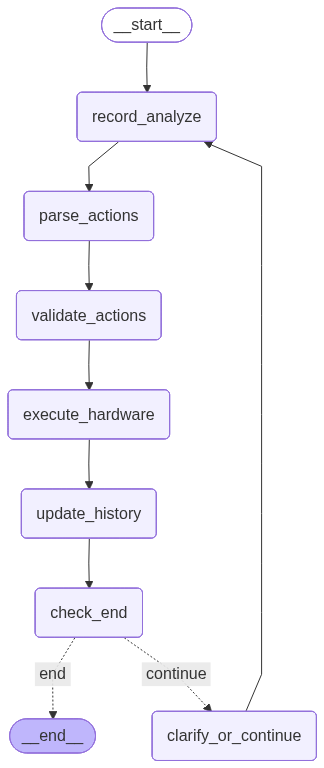

In [4]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))